# PCA Analysis with clustering


In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from kneed import KneeLocator
from functions.data_functions import load_data, connect_to_database
import warnings
warnings.filterwarnings(action='ignore')
from scipy import stats

Load the data

In [2]:
t1_df = load_data('BEACON', 't1_measures')
t2_df = load_data('BEACON', 't2_measures')

In [3]:
t1_df

,index,G_NNumber,oci_score_t1,bmi_t1,anxiety_t1,depression_t1,restraint_score_t1,eatinG_Nconcern_score_t1,shape_concern_score_t1,weight_concern_score_t1,global_score_t1,aq_score_t1,wsas_score_t1,group
0,0,G1001,3.0,18.328742,4.0,0.0,0.0,0.0,0.000,0.0,0.00000,1.0,0.0,HC_t1
1,1,G1002,3.0,20.202020,4.0,3.0,0.2,0.0,0.500,0.4,0.28000,2.0,0.0,HC_t1
2,2,G1004,4.0,21.011758,6.0,9.0,0.0,0.0,0.750,0.4,0.29000,3.0,0.0,HC_t1
3,3,G1006,2.0,NaN,2.0,6.0,0.0,0.2,1.125,0.8,0.53000,1.0,1.0,HC_t1
4,4,G1008,3.0,24.609375,9.0,4.0,0.0,0.0,0.125,0.2,0.08000,3.0,1.0,HC_t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,186,G2138,4.0,16.602388,8.0,3.0,0.0,0.2,3.250,1.2,1.16250,0.0,16.0,AN_t1
187,187,G2139,13.0,16.224986,12.0,11.0,3.2,1.8,1.375,0.6,1.74375,2.0,30.0,AN_t1
188,188,G2140,9.0,14.933853,8.0,7.0,5.0,4.6,6.000,4.8,5.10000,2.0,32.0,AN_t1
189,189,G2141,16.0,16.757637,12.0,7.0,4.6,3.2,5.625,4.2,4.40625,4.0,27.0,AN_t1


In [48]:
t2_df

,index,B-Number,aq_score_t2,anxiety_t2,depression_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,global_score_t2,group,wsas_score_t2,oci_score_t2,bmi_t2
0,0,B1003,1,4.0,2.0,0.0,0.0,0.000,0.0,0.00000,HC_t2,0.0,NaN,NaN
1,1,B1006,6,11.0,3.0,1.2,0.8,1.500,1.0,1.12500,HC_t2,7.0,10.0,21.218317
2,2,B1008,1,6.0,1.0,0.4,0.2,0.375,0.2,0.29375,HC_t2,0.0,4.0,19.526368
3,3,B1009,7,10.0,6.0,1.2,1.8,2.625,1.4,1.75625,HC_t2,4.0,18.0,31.503997
4,4,B1004,3,9.0,3.0,1.2,0.8,2.250,0.4,1.16250,HC_t2,2.0,27.0,24.683905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,128,B2092,2,13.0,5.0,1.4,2.0,3.250,1.6,2.06250,AN_t2,16.0,15.0,19.467401
129,129,B2090,4,14.0,3.0,1.4,2.0,2.125,2.0,1.88125,AN_t2,7.0,8.0,NaN
130,130,B2093,1,11.0,16.0,6.0,4.6,5.750,4.8,5.28750,AN_t2,29.0,9.0,14.733633
131,131,B2095,5,4.0,2.0,1.0,0.2,3.250,2.2,1.66250,AN_t2,7.0,7.0,22.395413


In [6]:
print(t1_df.isnull().sum())
print(f'-'*100,)
print(t2_df.isnull().sum())

G-Number                    0
oci_score_t1               16
bmi_t1                     26
anxiety_t1                 18
depression_t1              18
restraint_score_t1         22
eating_concern_score_t1    22
shape_concern_score_t1     22
weight_concern_score_t1    22
global_score_t1            22
aq_score_t1                15
wsas_score_t1              14
group                       0
dtype: int64
----------------------------------------------------------------------------------------------------
B-Number                    0
aq_score_t2                 0
anxiety_t2                  2
depression_t2               2
restraint_score_t2          3
eating_concern_score_t2     3
shape_concern_score_t2      3
weight_concern_score_t2     3
global_score_t2             3
group                       3
wsas_score_t2               3
oci_score_t2                7
bmi_t2                     23
dtype: int64


## Preprocessing

Due to the data being in different units this can cause some measures to be weighted more in the segmentation model compared with others. For example a difference in the ede-q between HC participants could be 0.5 however there could be a difference of 10 between the lowest and highest BMI.

To prevent this all the data is standardized by removing the mean and scaling to unit variance.

```z = (x - u) / s```

Where u is the mean and s is the standard variaces. 

In [7]:
scaler = StandardScaler()
t1_scaler = scaler.fit_transform(t1_df.dropna().drop(['G-Number', 'group'], axis=1))
t2_scaler = scaler.fit_transform(t2_df.dropna().drop(['B-Number', 'group'], axis=1))

## Dimensionality Reduction

In [8]:
t1_pca_model = PCA()
t1_pca_model.fit(t1_scaler)
t1_pca_scores = t1_pca_model.transform(t1_scaler)

t1_wcss = []

for cluster_number in range(1,21):
    kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    kmeans_pca.fit(t1_pca_scores)
    t1_wcss.append(kmeans_pca.inertia_)

t1_kl = KneeLocator(range(1, 21), t1_wcss, curve="convex", direction="decreasing")
print(t1_kl.elbow)

3


Text(0, 0.5, 'Cumulative Explained variance')

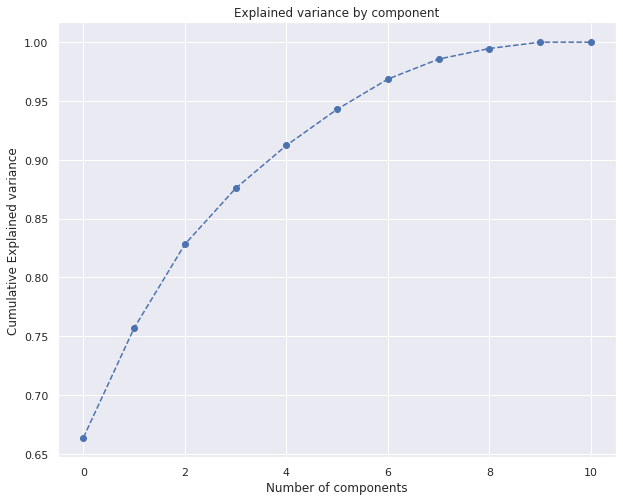

In [9]:
plt.figure(figsize=(10,8))
plt.plot(t1_pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

Text(0, 0.5, 'WCSS')

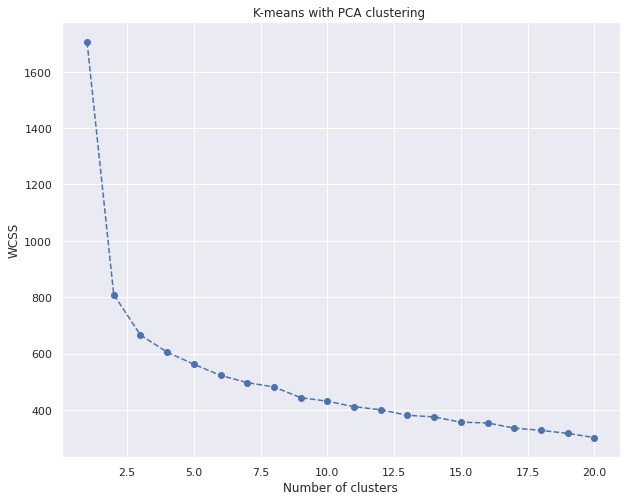

In [10]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), t1_wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [11]:
t2_pca_model = PCA()
t2_pca_model.fit(t2_scaler)
t2_pca_scores = t2_pca_model.transform(t2_scaler)

t2_wcss = []

for cluster_number in range(1,21):
    t2_kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    t2_kmeans_pca.fit(t1_pca_scores)
    t2_wcss.append(t2_kmeans_pca.inertia_)

t2_kl = KneeLocator(range(1, 21), t2_wcss, curve="convex", direction="decreasing")
print(t2_kl.elbow)

3


Text(0, 0.5, 'Cumulative Explained variance')

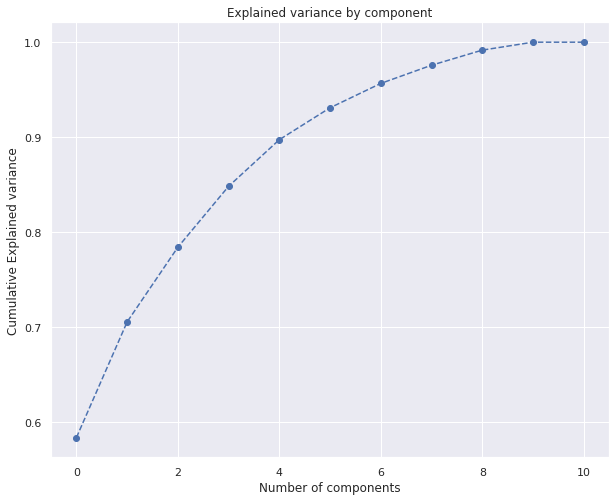

In [12]:
plt.figure(figsize=(10,8))
plt.plot(t2_pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

Text(0, 0.5, 'WCSS')

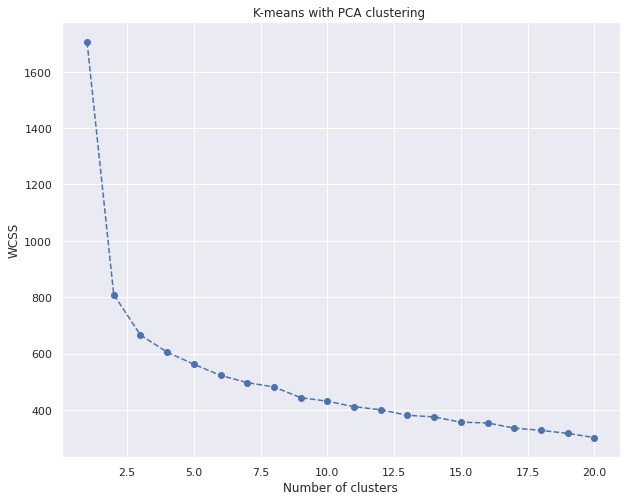

In [13]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), t2_wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [55]:
print('t1 explained variance ratio:\n', t1_pca_model.explained_variance_ratio_)
print('\nt2 explained variance ratio:\n', t2_pca_model.explained_variance_ratio_)

t1 explained variance ratio:
 [6.63903369e-01 9.31594790e-02 7.11246778e-02 4.75394626e-02
 3.64795577e-02 3.07051738e-02 2.56713565e-02 1.70012117e-02
 9.03675966e-03 5.37881190e-03 1.40587439e-07]

t2 explained variance ratio:
 [5.83888821e-01 1.21747172e-01 7.86221514e-02 6.40804994e-02
 4.90512761e-02 3.35821518e-02 2.56355686e-02 1.91467576e-02
 1.58865859e-02 8.35901614e-03 3.29244072e-33]


## Dataframes

In [28]:
t1_df_seg = pd.concat([t1_df.dropna().reset_index(drop=True), pd.DataFrame(t1_pca_scores)], axis=1)
t1_df_seg.columns.values[13:16] = ['comp_1', 'comp_2', 'comp_3']
t1_df_seg = t1_df_seg.drop([3 , 4, 5, 6, 7, 8, 9, 10], axis=1)
t1_df_seg

,G-Number,oci_score_t1,bmi_t1,anxiety_t1,depression_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1,global_score_t1,aq_score_t1,wsas_score_t1,group,comp_1,comp_2,comp_3
0,G1001,3.0,18.328742,4.0,0.0,0.0,0.0,0.000,0.0,0.00000,1.0,0.0,HC_t1,-3.319774,-0.009623,-0.988172
1,G1002,3.0,20.202020,4.0,3.0,0.2,0.0,0.500,0.4,0.28000,2.0,0.0,HC_t1,-2.913537,0.070571,-0.299912
2,G1004,4.0,21.011758,6.0,9.0,0.0,0.0,0.750,0.4,0.29000,3.0,0.0,HC_t1,-2.330221,0.827119,0.029195
3,G1008,3.0,24.609375,9.0,4.0,0.0,0.0,0.125,0.2,0.08000,3.0,1.0,HC_t1,-2.865158,0.610074,0.846223
4,G1010,3.0,22.718974,1.0,0.0,0.0,0.0,0.375,0.2,0.14000,2.0,1.0,HC_t1,-3.549291,-0.476134,0.393326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,G2137,8.0,14.512472,7.0,6.0,4.6,2.6,4.125,3.4,3.68125,2.0,10.0,AN_t1,1.260847,-1.322877,-1.481774
151,G2138,4.0,16.602388,8.0,3.0,0.0,0.2,3.250,1.2,1.16250,0.0,16.0,AN_t1,-1.402611,-0.245159,-1.579789
152,G2139,13.0,16.224986,12.0,11.0,3.2,1.8,1.375,0.6,1.74375,2.0,30.0,AN_t1,0.710268,0.959405,-1.566979
153,G2140,9.0,14.933853,8.0,7.0,5.0,4.6,6.000,4.8,5.10000,2.0,32.0,AN_t1,3.275019,-2.019297,-1.381370


<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

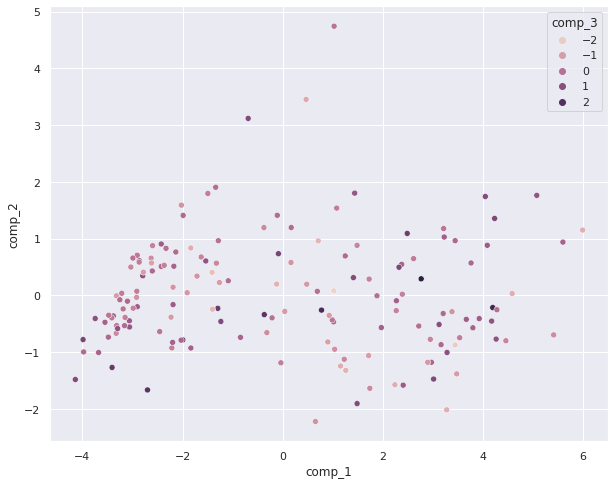

In [31]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', 'comp_3', data=t1_df_seg, hue='segment')

In [32]:
t2_df_seg = pd.concat([t2_df.dropna().reset_index(drop=True), pd.DataFrame(t2_pca_scores)], axis=1)

t2_df_seg.columns.values[13:16] = ['comp_1', 'comp_2', 'comp_3']
t2_df_seg = t2_df_seg.drop([3, 4, 5, 6, 7, 8, 9, 10], axis=1)
t2_df_seg

,B-Number,aq_score_t2,anxiety_t2,depression_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,global_score_t2,group,wsas_score_t2,oci_score_t2,bmi_t2,comp_1,comp_2,comp_3
0,B1006,6,11.0,3.0,1.2,0.8,1.500,1.0,1.12500,HC_t2,7.0,10.0,21.218317,-1.233985,1.136890,0.063579
1,B1008,1,6.0,1.0,0.4,0.2,0.375,0.2,0.29375,HC_t2,0.0,4.0,19.526368,-3.092168,-0.202105,-0.868384
2,B1009,7,10.0,6.0,1.2,1.8,2.625,1.4,1.75625,HC_t2,4.0,18.0,31.503997,-0.758996,0.600847,2.721390
3,B1004,3,9.0,3.0,1.2,0.8,2.250,0.4,1.16250,HC_t2,2.0,27.0,24.683905,-1.508218,0.232314,0.887047
4,B1011,1,1.0,0.0,0.8,0.0,0.375,0.4,0.39375,HC_t2,0.0,3.0,20.446742,-3.427371,-0.749844,-0.836024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,B2091,5,14.0,11.0,2.4,1.6,4.750,2.0,2.68750,AN_t2,24.0,24.0,15.084373,2.086426,1.213599,-0.510481
101,B2092,2,13.0,5.0,1.4,2.0,3.250,1.6,2.06250,AN_t2,16.0,15.0,19.467401,0.222572,-0.068561,-0.319396
102,B2093,1,11.0,16.0,6.0,4.6,5.750,4.8,5.28750,AN_t2,29.0,9.0,14.733633,4.714841,-1.933827,-0.874109
103,B2095,5,4.0,2.0,1.0,0.2,3.250,2.2,1.66250,AN_t2,7.0,7.0,22.395413,-1.342321,-0.220824,0.270768


<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

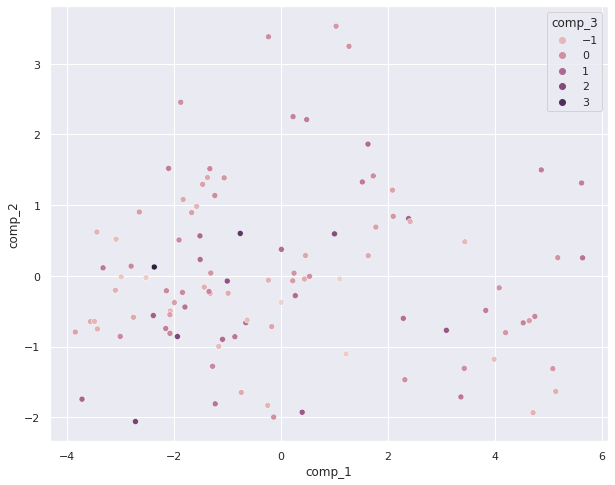

In [33]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', 'comp_3', data=t2_df_seg, hue='segment')

## Examine the relationship between components and measures

In [20]:
measures_t1 = ['oci_score_t1', 'bmi_t1', 'anxiety_t1', 'depression_t1', 'restraint_score_t1', 'eating_concern_score_t1', 'shape_concern_score_t1', 'weight_concern_score_t1', 'global_score_t1', 'aq_score_t1', 'wsas_score_t1']

correlations_t1 = {
    'comp_1': {},
    'comp_2': {},
    'comp_3': {},
}

for component in correlations_t1.keys():
    for measure in measures_t1:
        correlations_t1[component][measure] =  stats.pearsonr(t1_df_seg[component], t1_df_seg[measure])[0]

measures_t2 = ['oci_score_t2', 'bmi_t2', 'anxiety_t2', 'depression_t2', 'restraint_score_t2', 'eating_concern_score_t2', 'shape_concern_score_t2', 'weight_concern_score_t2', 'global_score_t2', 'aq_score_t2', 'wsas_score_t2']

correlations_t2 = {
    'comp_1': {},
    'comp_2': {},
    'comp_3': {},
}

for component in correlations_t2.keys():
    for measure in measures_t2:
        correlations_t2[component][measure] =  stats.pearsonr(t2_df_seg[component], t2_df_seg[measure])[0]


{'oci_score_t1': 0.7215965020632784, 'bmi_t1': -0.574803534326801, 'anxiety_t1': 0.7593209401581212, 'depression_t1': 0.7919495453078673, 'restraint_score_t1': 0.874791903679969, 'eating_concern_score_t1': 0.9351766682958331, 'shape_concern_score_t1': 0.9156543980044717, 'weight_concern_score_t1': 0.9086351792137756, 'global_score_t1': 0.9553561963076209, 'aq_score_t1': 0.5742068332005185, 'wsas_score_t1': 0.8377398039735623}


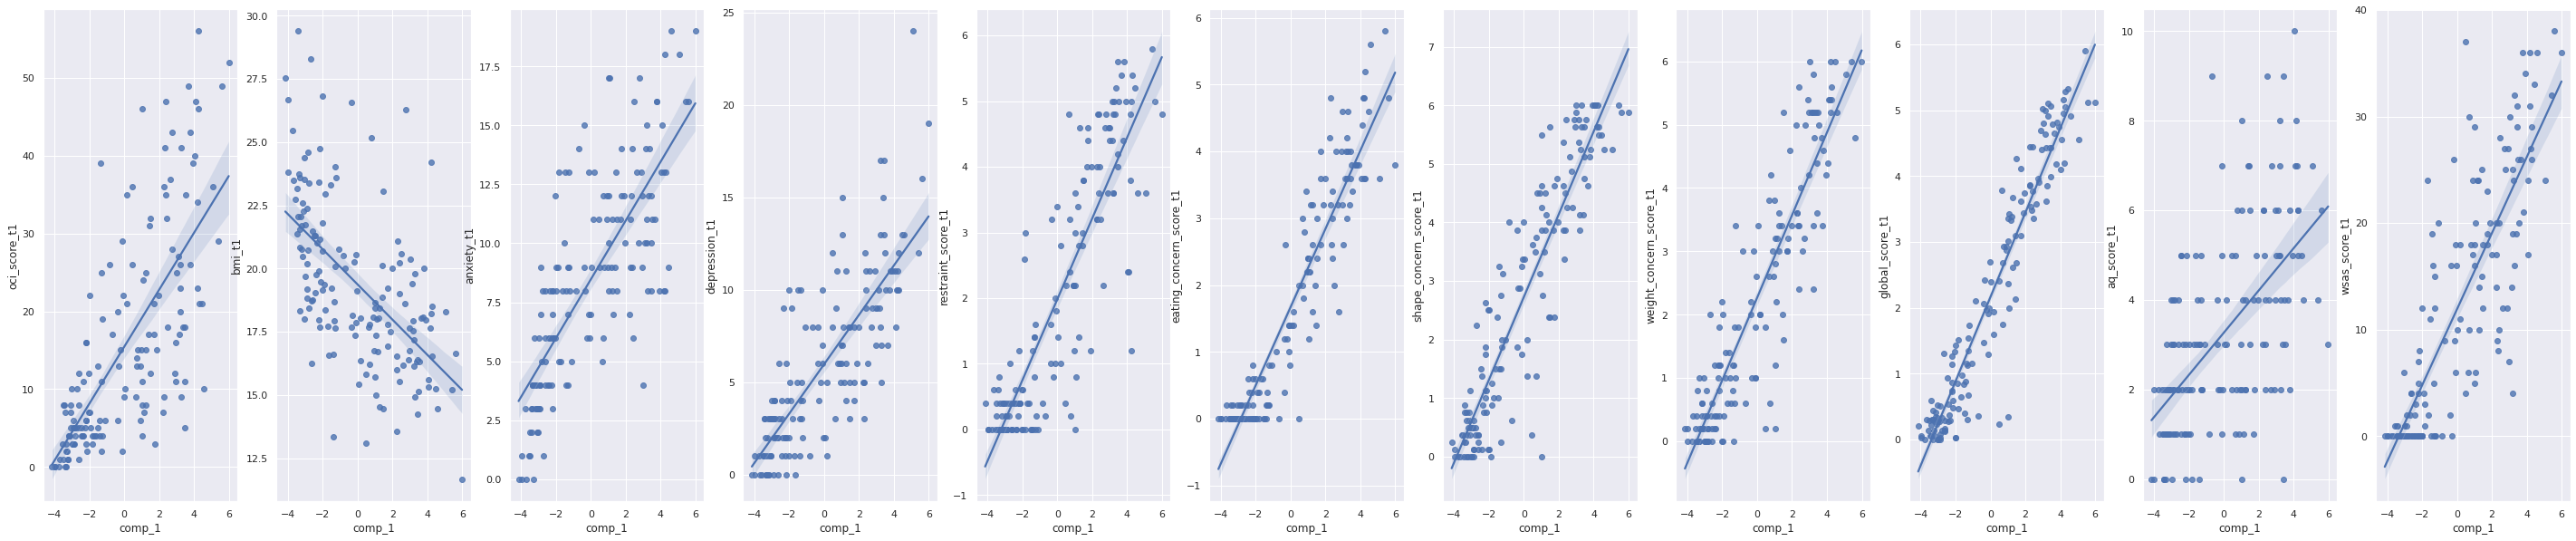

In [21]:
fig, ax = plt.subplots(1, 11,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_1',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_1'])

{'oci_score_t1': 0.3060280163628223, 'bmi_t1': -0.24668141305899807, 'anxiety_t1': 0.3900456837106705, 'depression_t1': 0.31462378300981003, 'restraint_score_t1': -0.29922271239676834, 'eating_concern_score_t1': -0.20273692619253614, 'shape_concern_score_t1': -0.2857997436642483, 'weight_concern_score_t1': -0.2886164289218321, 'global_score_t1': -0.2859054407705909, 'aq_score_t1': 0.48622524431485725, 'wsas_score_t1': 0.07315260323233869}


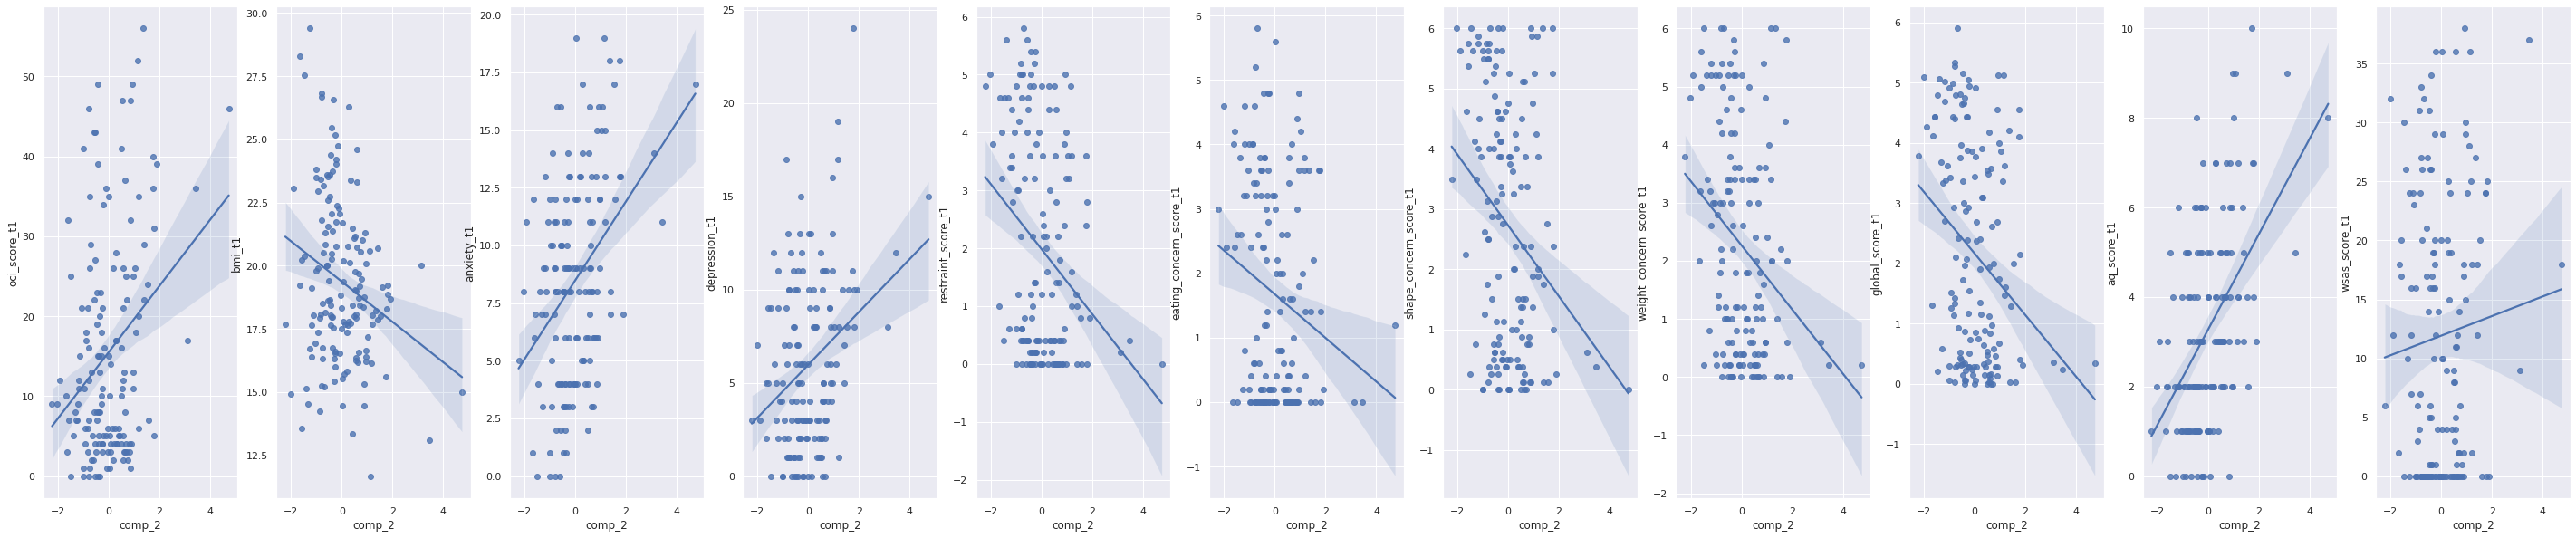

In [22]:
fig, ax = plt.subplots(1, 11,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_2',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_2'])

{'oci_score_t1': 0.24435928634058293, 'bmi_t1': 0.7125413176863797, 'anxiety_t1': -0.07951028445854012, 'depression_t1': -0.05183468036604227, 'restraint_score_t1': -0.03756198064718611, 'eating_concern_score_t1': -0.04599709691008105, 'shape_concern_score_t1': 0.07427072621321659, 'weight_concern_score_t1': 0.1336441136311754, 'global_score_t1': 0.036548923469500484, 'aq_score_t1': 0.41674569204011136, 'wsas_score_t1': -0.06340209596019591}


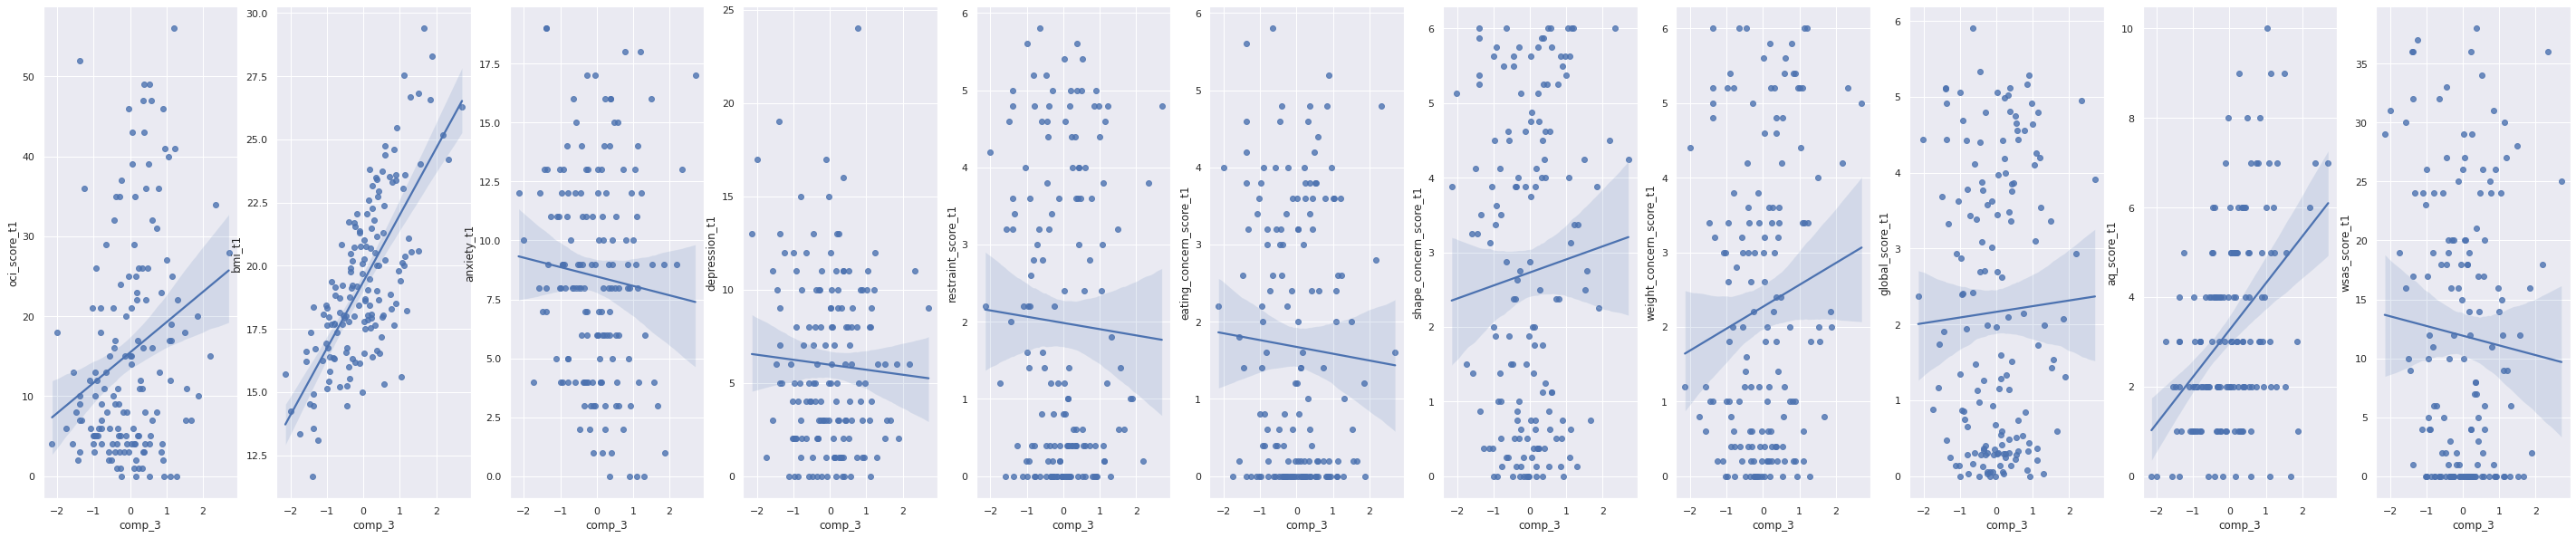

In [23]:
fig, ax = plt.subplots(1, 11,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_3',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_3'])

{'oci_score_t2': 0.6646660083396956, 'bmi_t2': -0.4646785234379216, 'anxiety_t2': 0.7585871945513171, 'depression_t2': 0.7122640640944345, 'restraint_score_t2': 0.84249307587504, 'eating_concern_score_t2': 0.8759852112597066, 'shape_concern_score_t2': 0.8859963134833809, 'weight_concern_score_t2': 0.8834291862523684, 'global_score_t2': 0.948121968841161, 'aq_score_t2': 0.3501015661326489, 'wsas_score_t2': 0.7862618713132141}


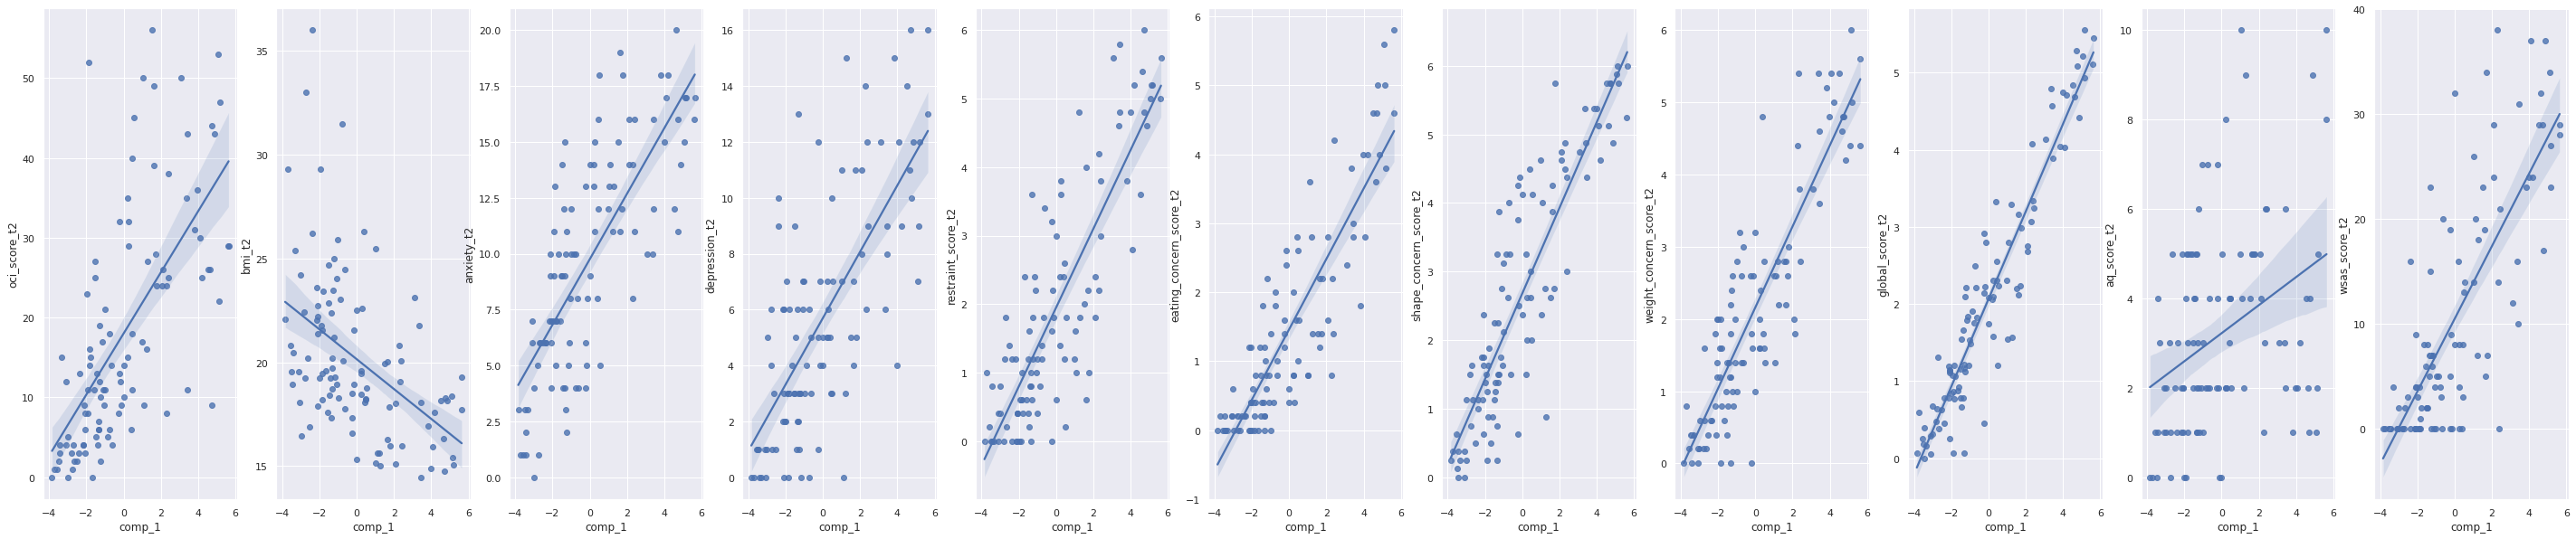

In [24]:
fig, ax = plt.subplots(1, 11,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_1',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_1'])

{'oci_score_t2': 0.33686994279893134, 'bmi_t2': -0.2679496533558848, 'anxiety_t2': 0.3744038744481318, 'depression_t2': 0.25983538680230006, 'restraint_score_t2': -0.3006660592717974, 'eating_concern_score_t2': -0.17336270715321633, 'shape_concern_score_t2': -0.2754030359856213, 'weight_concern_score_t2': -0.31298118809887343, 'global_score_t2': -0.291895093387222, 'aq_score_t2': 0.7351702113442059, 'wsas_score_t2': 0.16220689537295968}


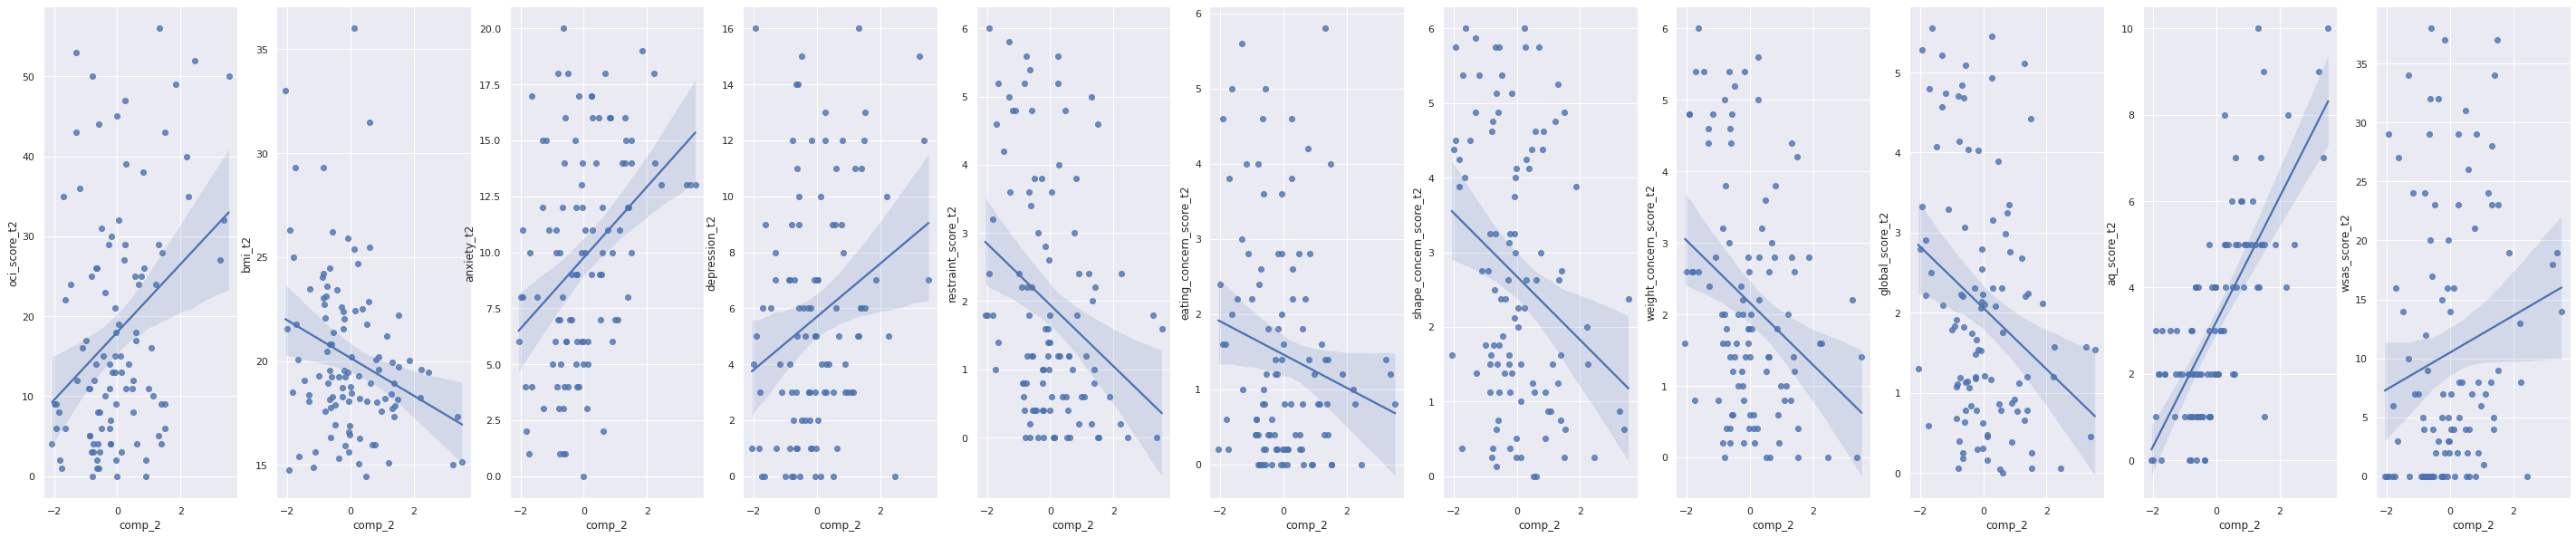

In [25]:
fig, ax = plt.subplots(1, 11,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_2',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_2'])

{'oci_score_t2': 0.16965725770461842, 'bmi_t2': 0.8212908477288421, 'anxiety_t2': 0.1008458696923228, 'depression_t2': 0.2986502387046991, 'restraint_score_t2': -0.06045762828034097, 'eating_concern_score_t2': -0.15603149363890015, 'shape_concern_score_t2': 0.07785632841207889, 'weight_concern_score_t2': 0.12339330408882139, 'global_score_t2': 0.0004489306488197487, 'aq_score_t2': 0.09777567295549694, 'wsas_score_t2': -0.057713241487411936}


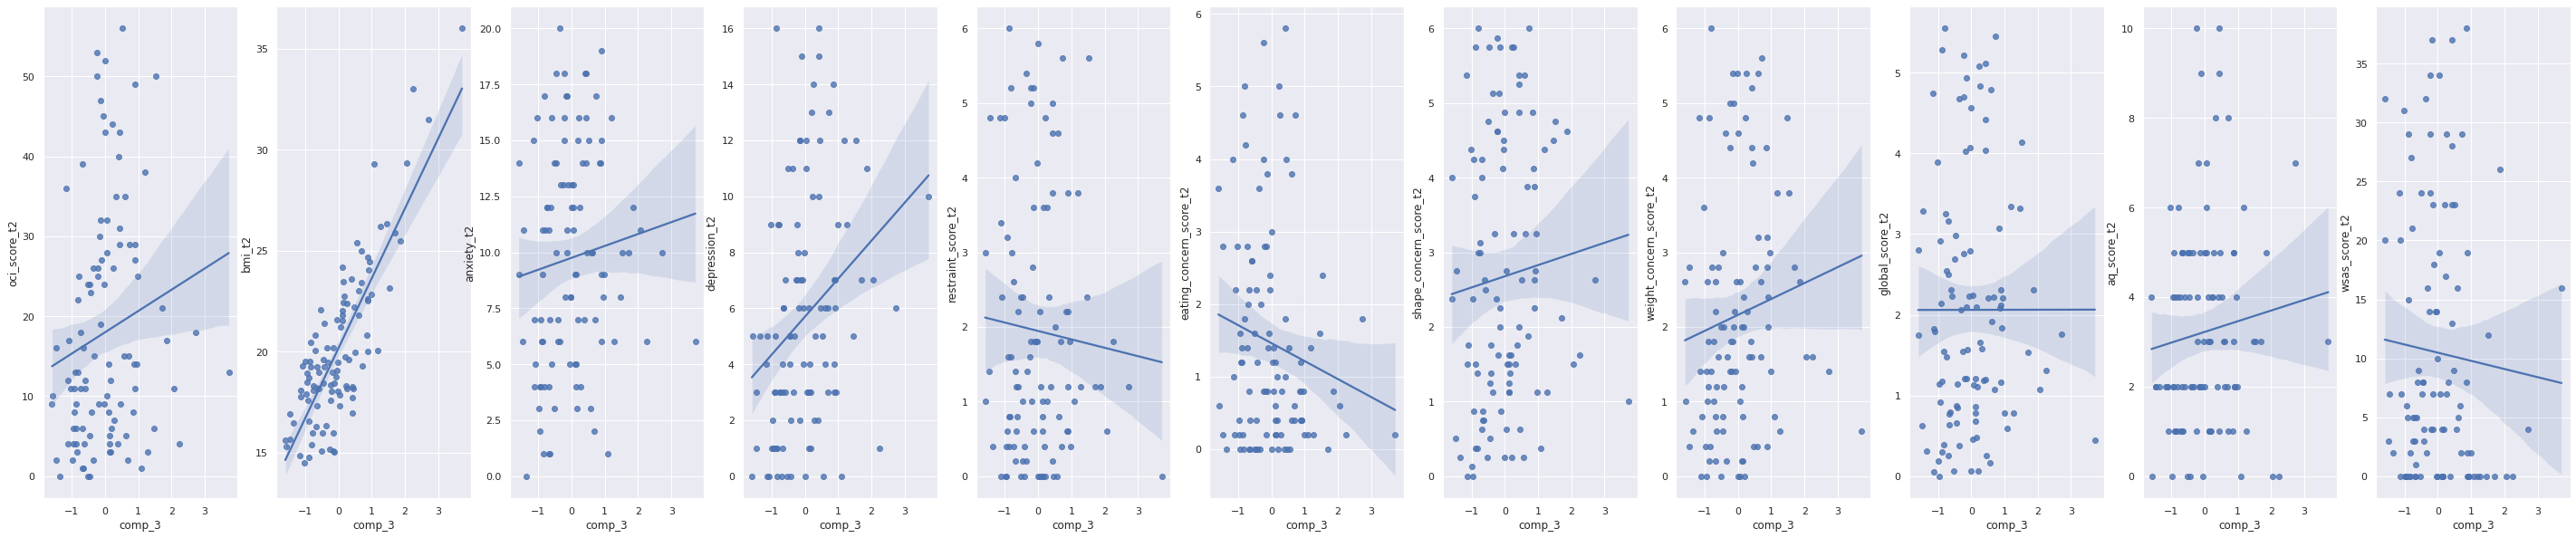

In [26]:
fig, ax = plt.subplots(1, 11,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_3',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_3'])

## Save dataframes to sql database

In [49]:
pca_t1 = t1_df_seg[['G-Number', 'comp_1', 'comp_2', 'comp_3']]
pca_t2 = t2_df_seg[['B-Number', 'comp_1', 'comp_2', 'comp_3']]

In [52]:
"""

Un comment this section to run. This is done just in case run all is clicked on the notebook 

connector = connect_to_database('BEACON')
pca_t1.to_sql('pca_t1', connector)
pca_t2.to_sql('pca_t2', connector)

"""